## Vogelscraper - A bird species scraper in a jupyter notebook
This notebook scrapes the Dutch birding site waarneming.nl for bird photos and metadata

Potential improvements: 
* Refactoring the bird_scraper call to be more modular
* Be able to pause scraping
* Enabling multiprocessing (bit of a moot point, since I deliberately space out requests to be 1 second in between)
* Use flickr data as well
* ~~Include metadata in the dataset.

## Goal:
* Collect photos of birds, transform them into a uniform shape for training data and store both the raw and processed versions along with some metadata

## See also:
https://github.com/jeffluppes/birdclassification

## Author
Jeffrey Luppes - jeffluppes@gmail.com

In [1]:
import requests
from bs4 import BeautifulSoup
import shutil
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from os import listdir
from os.path import isfile, join
import random
import cv2
import numpy as np
import pandas as pd
import time
import json
import multiprocessing as mp

#settings for folders
RAWFOLDER = 'data/raw'
PROCESSEDFOLDER = 'data/edited'

# how many images to retrieve per species
MAXIMAGES = 10000

# the number of images returned per page (needed for pagination)
IMAGESPERPAGE = 24

# unfortunately, there are many species that we cannot directly query for - just try querying for 'kwikstaart'!
# there are 34 species... which one is relevant for our model?  Futhermore, they're all returned in alphabetical
# format. It would have been more elegant to query for it, but alas, I did that in advance
species = [{
    'name': 'pimpelmees',
    'id': '161'
}, {
    'name': 'koolmees',
    'id': '140'
}, {
    'name': 'staartmees',
    'id': '181'
}, {
    'name': 'kuifmees',
    'id': '145'
}, {
    'name': 'vink',
    'id': '193'
}, {
    'name': 'merel',
    'id': '150'
}, {
    'name': 'spreeuw',
    'id': '180'
}, {
    'name': 'ringmus',
    'id': '166'
}, {
    'name': 'huismus',
    'id': '122'
}, {
    'name': 'geelgors',
    'id': '55'
}, {
    'name': 'groenling',
    'id': '261771'
}, {
    'name': 'heggenmus',
    'id': '118'
}, {
    'name': 'boomkruiper',
    'id': '71'
}, {
    'name': 'boomklever',
    'id': '70'
}, {
    'name': 'roodborstje',
    'id': '168'
}, {
    'name': 'grotebontespecht',
    'id': '109'
}, {
    'name': 'ekster',
    'id': '87'
}, {
    'name': 'putter',
    'id': '162'
},{
    'name': 'winterkoning',
    'id': '199'
},{
    'name': 'zanglijster',
    'id': '204'
},{
    'name': 'houtduif',
    'id': '120'
},{
    'name': 'turksetortel',
    'id': '191'
},{
    'name': 'holenduif',
    'id': '119'
},{
    'name': 'wittekwikstaart',
    'id': '202'
},{
    'name': 'groenespecht',
    'id': '40'
},{
    'name': 'vlaamsegaai',
    'id': '92'
},{
    'name': 'keep',
    'id': '127'
},{
    'name': 'koperwiek',
    'id': '141'
},{
    'name': 'kramsvogel',
    'id': '143'
},{
    'name': 'wielewaal',
    'id': '350'
},{
    'name': 'kauw',
    'id': '126'
},{
    'name': 'zwartekraai',
    'id': '208'
},{
    'name': 'kokmeeuw',
    'id': '138'
}]

# CC-BY-NC-ND forbids use as training data (although thats an open debate)
# Additionally, the all rights reserved license seems good to not infringe upon
# Attribution can be done by logging which files are used
ALLOWED_LICENCES = ['CC-BY-NC', 'CC-BY', '-', 'CC-BY-NC-SA']

In [2]:
print(f'There are {len(species)} birds on the scraping list.')

There are 33 birds on the scraping list.


In [3]:
def get_and_store_image(url: str, path: str):
    '''Obtain an image fm the world wide web and store it in the path specified'''
    response = requests.get(url, stream=True)
    with open(path, 'wb') as out_file:
        shutil.copyfileobj(response.raw, out_file)
    del response  
    
def center_image(img):
    '''Convenience function to return a centered image'''
    size = [256,256]
    
    img_size = img.shape[:2]
    
    # centering
    row = (size[1] - img_size[0]) // 2
    col = (size[0] - img_size[1]) // 2
    resized = np.zeros(list(size) + [img.shape[2]], dtype=np.uint8)
    resized[row:(row + img.shape[0]), col:(col + img.shape[1])] = img

    return resized

In [4]:
def show_random_img_from_folder(folder: str):
    '''Show a random image from the given folder'''
    
    filelist = [f for f in listdir(folder) if isfile(join(folder, f))]
    imglocation = random.choice(filelist)
    
    img=mpimg.imread(folder+'/'+imglocation)
    imgplot = plt.imshow(img)
    plt.show()
    
    print(imglocation)

In [5]:
def convert_and_store_img(inputpath: str, outputpath: str):
    '''Converts an image and resizes it, stores it to disk (ssd in this case)'''
    
    # try-catch is necessary here because: 
    # a) images might be really small for some reason
    # b) images might be served with a 0-dimension from waarneming.nl (e.g. 512x0) possibly corrupted
    #    during upload / download
    # bit of an antipattern for sure.
    try:
        img = cv2.imread(inputpath)
        
        #calculate tile size
        if(img.shape[0] > img.shape[1]):
            tile_size = (int(img.shape[1]*256/img.shape[0]),256)
        else:
            tile_size = (256, int(img.shape[0]*256/img.shape[1]))

        #centering + actual resizing
        img = center_image(cv2.resize(img, dsize=tile_size))

        #output should be 224*224px for a quick vggnet16
        img = img[16:240, 16:240]

        cv2.imwrite(outputpath, img)
        
    except:
        print(inputpath)
        pass

In [6]:
def get_photoid_list(species: str) -> list:
    '''Convenience function to return a list of (already-scraped) photo ids for a given species'''
    ids = []
    for r, d, f in os.walk('data/raw/'+species):
        for file in f:
            ids.append(file.split('.')[0])   
    
    return ids

In [13]:
def bird_scraper(species: str, identifier: str):
    '''TODO refactor this at some point. Code has in-line comments for doc'''
    photolinks = []
    
    timeframes = ['2019-02-20&before_date=2020-02-20',
        '2018-02-20&before_date=2019-02-20', 
        '2017-02-20&before_date=2018-02-20',
        '2016-02-20&before_date=2017-02-20',
        '2015-02-20&before_date=2016-02-20',
        '2014-02-20&before_date=2015-02-20',
        '2013-02-20&before_date=2014-02-20']
    
    more_frames = ['2012-02-20&before_date=2013-02-20',
        '2011-02-20&before_date=2012-02-20',
        '2010-02-20&before_date=2011-02-20']
    
    time_index = 0
    
    # pagination of the photo gallery starts at 1 and not 0.
    # I also suspect that the gallery is limited to the last year if querying for large time frames.
    
    while time_index <= len(timeframes)-1:
        if len(photolinks) > MAXIMAGES:
            break
        # stop condition: if we've reached the end of the time frames or the max links we wanted to crawl
        
        print('So far the search for {} has returned {} photos'.format(species, len(photolinks)))
        results = True
        
        while results:
            try:
                for i in range(1,100):
                    #pause for one second out of courtesy
                    time.sleep(1)

                    # construct the url
                    URL = 'https://waarneming.nl/species/'+identifier+'/photos/?after_date='+timeframes[time_index]+'&page='+str(i)

                    # fetch the url and content
                    page = requests.get(URL)
                    soup = BeautifulSoup(page.content, 'html.parser')
                    tags=soup.findAll('img',{"class":"app-ratio-box-image"})
                    #print('found {} image-links!'.format(len(photolinks)))

                    if len(tags) == 0:
                        results = False
                        break

                    photolinks += tags
            except Exception as e:
                print(str(e))
                
            results = False
            time_index += 1


    
    #Show a count of how many we've found
    print(f'Found {photolinks} photos for {species}.')
    
    #make folders if they don't yet exist
    if not os.path.exists(RAWFOLDER+'/'+species):
        os.makedirs(RAWFOLDER+'/'+species)

    if not os.path.exists(PROCESSEDFOLDER+'/'+species):
        os.makedirs(PROCESSEDFOLDER+'/'+species)
        
    # get the photoids we already have scraped from - the links change
    # (seems to be some kind of load balancing for storage)
    photoids = get_photoid_list(species)
    new_photos = 0
    
    metadata = []
    # download photos and store them in their new home - the folders we just made
    for link in photolinks:
        
        #url without gibberish
        url = link['src'].split('?w')[0]
        #obtain filename from url
        filename = url.split('/')[5]
        
        #check if we have encountered this photo before- will be substantially slower with large n
        if filename.split('.')[0] not in photoids: 
            
            # we have a new photo, so lets check the metadata first
            meta = get_metadata(filename.split('.')[0])
            
            if meta:
                #print(meta['Licentie'])
                meta['photoid'] = filename
                metadata.append(meta)
                
                if meta['Licentie'] in ALLOWED_LICENCES:
                    path = RAWFOLDER+'/'+species+'/'+filename
                    get_and_store_image(url, path)

                    #also resize the image and store them seperately
                    outputpath = PROCESSEDFOLDER+'/'+species+'/'+filename.split('.')[0]+'.png'

                    convert_and_store_img(path, outputpath)
                    new_photos += 1
                    
                    #pause for one second out of courtesy
                    time.sleep(1)

    print(f'Found {new_photos} new photos of {species}')
    
    #store metadata to flat file
    store_meta(species, metadata)

In [14]:
def store_meta(species: str, meta: list):
    '''Store metadata to file for later use/verification'''
    
    with open(f'txtfiles/{species}.txt', 'a+', encoding="utf-8") as f:
        for item in meta:
            f.write("%s\n" % item)

In [15]:
def get_metadata(photoid=24691898) -> dict:
    '''Given a photo-id, return metadata in a dict'''
    
    url = 'https://waarneming.nl/photos/'+str(photoid)
    page = requests.get(url)
    soup = BeautifulSoup(page.content, 'html.parser')
    tags=soup.find('table',{"class":"table app-content-section"})
    meta =  {}
    
    if tags:
        # find all table rows
        rows = tags.find_all('tr')
        values = []
        keys = []
        # get the table content and return as two lists
        for row in rows:
            # actual content is listed in the <td>, while <th> holds the titles. 
            descriptions = row.find_all('th')
            cols = row.find_all('td')
            for idx, ele in enumerate(descriptions):
                keys.append(ele.text.strip())
                values.append(cols[idx].text.strip())

        #create a dict out of the data we fetched
        meta = dict(zip(keys, values))  

    return meta

In [16]:
#check if the metadata call returns the right stuff
get_metadata()

{'Type': 'Foto',
 'Soort': 'Pestvogel Bombycilla garrulus',
 'Levensstadium': 'onbekend',
 'Geslacht': 'onbekend',
 'Datum': '2020-01-25',
 'Gebruiker': 'Luuk Punt',
 'Locatie': 'Almere - Noorderplassen - Woonwijk (oud) (FL)',
 'Validatiestatus': 'goedgekeurd (automatische validatie)',
 'Licentie': 'CC-BY-NC-ND',
 'Views': '102',
 'Likes': '0'}

In [ ]:
# small tester to see if any of this looks good
bird_scraper('turksetortel', '191')
show_random_img_from_folder(RAWFOLDER+'/turksetortel')

So far the search for turksetortel has returned 0 photos
So far the search for turksetortel has returned 1226 photos
So far the search for turksetortel has returned 2366 photos
So far the search for turksetortel has returned 3388 photos
So far the search for turksetortel has returned 4345 photos
So far the search for turksetortel has returned 5149 photos
So far the search for turksetortel has returned 5993 photos
Found 6837 photos for turksetortel.


So far the search for kauw has returned 0 photos
So far the search for kauw has returned 2376 photos
So far the search for kauw has returned 4735 photos
So far the search for kauw has returned 7089 photos
So far the search for kauw has returned 9457 photos
Found 11823 photos for kauw.
Found 4952 new photos of kauw
kauw:


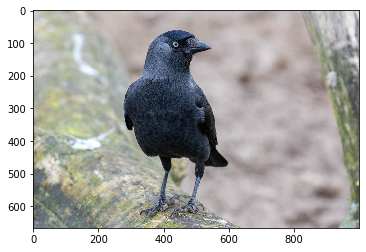

24774647.jpg
So far the search for zwartekraai has returned 0 photos
So far the search for zwartekraai has returned 2376 photos
So far the search for zwartekraai has returned 4752 photos
So far the search for zwartekraai has returned 7124 photos
So far the search for zwartekraai has returned 9492 photos
Found 11857 photos for zwartekraai.
data/raw/zwartekraai/21150002.jpg
data/raw/zwartekraai/15454868.jpg
Found 5147 new photos of zwartekraai
zwartekraai:


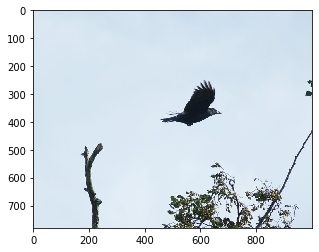

23717766.jpg
So far the search for kokmeeuw has returned 0 photos
So far the search for kokmeeuw has returned 2376 photos
So far the search for kokmeeuw has returned 4752 photos
So far the search for kokmeeuw has returned 7128 photos
So far the search for kokmeeuw has returned 9504 photos
Found 11880 photos for kokmeeuw.
data/raw/kokmeeuw/12695570.jpg
Found 3753 new photos of kokmeeuw
kokmeeuw:


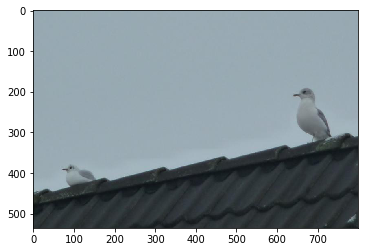

1741949.jpg


In [17]:
# all right, we're good to go!
for s in species[30:]:
    bird_scraper(s['name'], s['id'])
    
    # show a random photo to brighten the day
    print(str(s['name'])+':')
    show_random_img_from_folder(RAWFOLDER+'/'+s['name'])